In [1]:
import logging
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import numpy as np
import random
import seaborn as sns
import pandas as pd
import statistics as stat
import os
import yaml
import glob

# WHERE TO SAVE THE FIGURES?
save_loc = "/home/blr7rng/Documents/thesis/msc-thesis/j/diff_maps/"

# Import data

In [2]:
data = {"AGVs": [], "randseed": [], "map": [], "delay": [], "horizon": [], "total_time": [], "improvement": [], "cost_func": []}

yaml_list_general    = glob.glob("general/*.yaml")
yaml_list_halfgen    = glob.glob("halfgen/*.yaml")
yaml_list_nuernberg  = glob.glob("nuernberg/*.yaml")
yaml_list_islands    = glob.glob("islands/*.yaml")

maps_list = [yaml_list_general, yaml_list_halfgen, yaml_list_nuernberg, yaml_list_islands]

i = 0
map_names = ["general", "halfgen", "nuernberg", "islands"]
for map_files in maps_list:
    map_name = map_names[i]
    i += 1
    for file in map_files:
    
        split_filename = file.split("_")
        horizon = str(split_filename[-1].split(".")[0])
        delay = str(split_filename[-3])
        seed = str(split_filename[-5])
        AGVs = str(split_filename[-7])
#         costfunc = str(split_filename[-9])

        with open(file, "r") as stream:
            yaml_data = yaml.safe_load(stream)
            cumulative_time = yaml_data["results"]["total time"]
            data["AGVs"].append(int(AGVs))
            data["randseed"].append(int(seed))
            data["map"].append(map_name)
            data["delay"].append(int(delay))
            data["horizon"].append(int(horizon))
            data["total_time"].append(int(cumulative_time))
            data["improvement"].append(int(cumulative_time))
#             data["cost_func"].append(str(costfunc))
        


In [3]:
df = pd.DataFrame(data, columns=["AGVs", "randseed", "map", "delay", "horizon", "total_time", "improvement"])
# Get the 0 horizon data
df_0 = df[df.horizon == 0]

newdata = {"AGVs": [], "randseed": [], "map": [], "delay": [], "horizon": [], "total_time": [], "improvement": []}

no_baseline_cnt = 0
baseline_cnt = 0
no_baseline_list = []

for index, row in df.iterrows():
    AGVs = row["AGVs"]
    randseed = row["randseed"]
    map_name = row["map"]
    delay = row["delay"]
    horizon = row["horizon"]
    total_time = row["total_time"]
#     cost_func = row["cost_func"]
    
    try: 
        baseline = df_0[(df_0.AGVs == AGVs) & (df_0.randseed == randseed) & (df_0.map == map_name)  & (df_0.delay == delay)].iloc[0]
        baseline_time = baseline["total_time"]
        improvement = 100*(baseline_time-total_time)/baseline_time
        newdata["AGVs"].append(int(AGVs))
        newdata["randseed"].append(int(randseed))
        newdata["map"].append(map_name)
        newdata["delay"].append(int(delay))
        newdata["horizon"].append(int(horizon))
        newdata["total_time"].append(int(total_time))
        newdata["improvement"].append(float(improvement))
#         newdata["cost_func"].append(cost_func)
        baseline_cnt += 1
    except IndexError:
        # if no baseline (Horizon = 0) is found, do not add this data: cannot be compared
        no_baseline_cnt += 1
        no_baseline_str = str(AGVs) + " \t " + str(randseed) + " \t " + str(delay) + " \t " + str(horizon) + " \t " + str(cost_func)
        no_baseline_list.append(no_baseline_str)
        
print("Baselines found: {}".format(baseline_cnt))
print("No baseline count: {}".format(no_baseline_cnt))
print("List of baselines missing:")
print("AGVs \t seed \t delay \t horizon")
print("---------------------------------")
for row in no_baseline_list:
    print(row)
print("---------------------------------")

dfnew = pd.DataFrame(newdata, columns=["AGVs", "randseed", "map", "delay", "horizon", "total_time", "improvement"])
# print(dfnew)

df_actual_data = dfnew[dfnew.horizon == 5]
print(df_actual_data)

Baselines found: 929
No baseline count: 0
List of baselines missing:
AGVs 	 seed 	 delay 	 horizon
---------------------------------
---------------------------------
     AGVs  randseed      map  delay  horizon  total_time  improvement
0      40         7  general     10        5        1968    15.427589
1      50         4  general     10        5        2494     3.557618
2      25        17  general     10        5        1430     7.022107
3      30         7  general     10        5        1372     4.323570
6      40         4  general     10        5        1852     6.037544
..    ...       ...      ...    ...      ...         ...          ...
919    50        12  islands     10        5        5067     6.873736
920    30         6  islands     10        5        2600     6.103286
921    40        14  islands     10        5        3940     3.384012
926    60         6  islands     10        5        6198     7.451098
927    40         6  islands     10        5        3484     7.

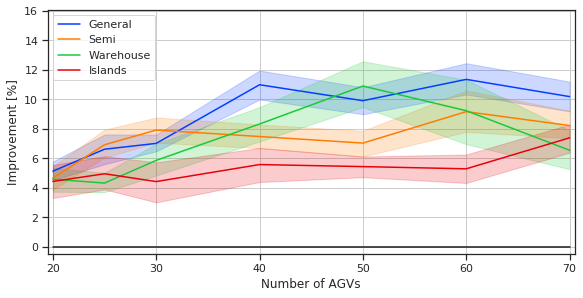

In [4]:
sns.set(style="ticks")
sns.set_palette("bright")
sns_col = sns.color_palette("bright", n_colors=4)
save_diff_maps = "/home/blr7rng/Documents/thesis/msc-thesis/j/diff_maps/"

plt.figure()
plt.grid()
g = sns.lineplot(x="AGVs", y="improvement",
             hue="map",
             ci=64,
             data=df_actual_data,
             legend="full",
             palette=sns_col)

plt.xlabel("Number of AGVs")
plt.ylabel("Improvement [%]")
plt.grid(True)
plt.ylim(-0.5,16.1)
plt.xlim(19.5,70.5)
plt.plot([20, 70],[0, 0],'k-')
plt.legend(loc="upper left")

which
ax = plt.gca()
ax.figure.set_size_inches(8,4)
plt.subplots_adjust(left=0.08, bottom=0.13, right=0.995, top=0.98, wspace=None, hspace=None)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles=handles[1:], labels=labels[1:], loc="upper left")
legend.texts[0].set_text("General")
legend.texts[1].set_text("Semi")
legend.texts[2].set_text("Warehouse")
legend.texts[3].set_text("Islands")

plt.savefig(save_diff_maps + "diff_maps.pdf", format="pdf", pad_inches=0.01, transparent=True)
